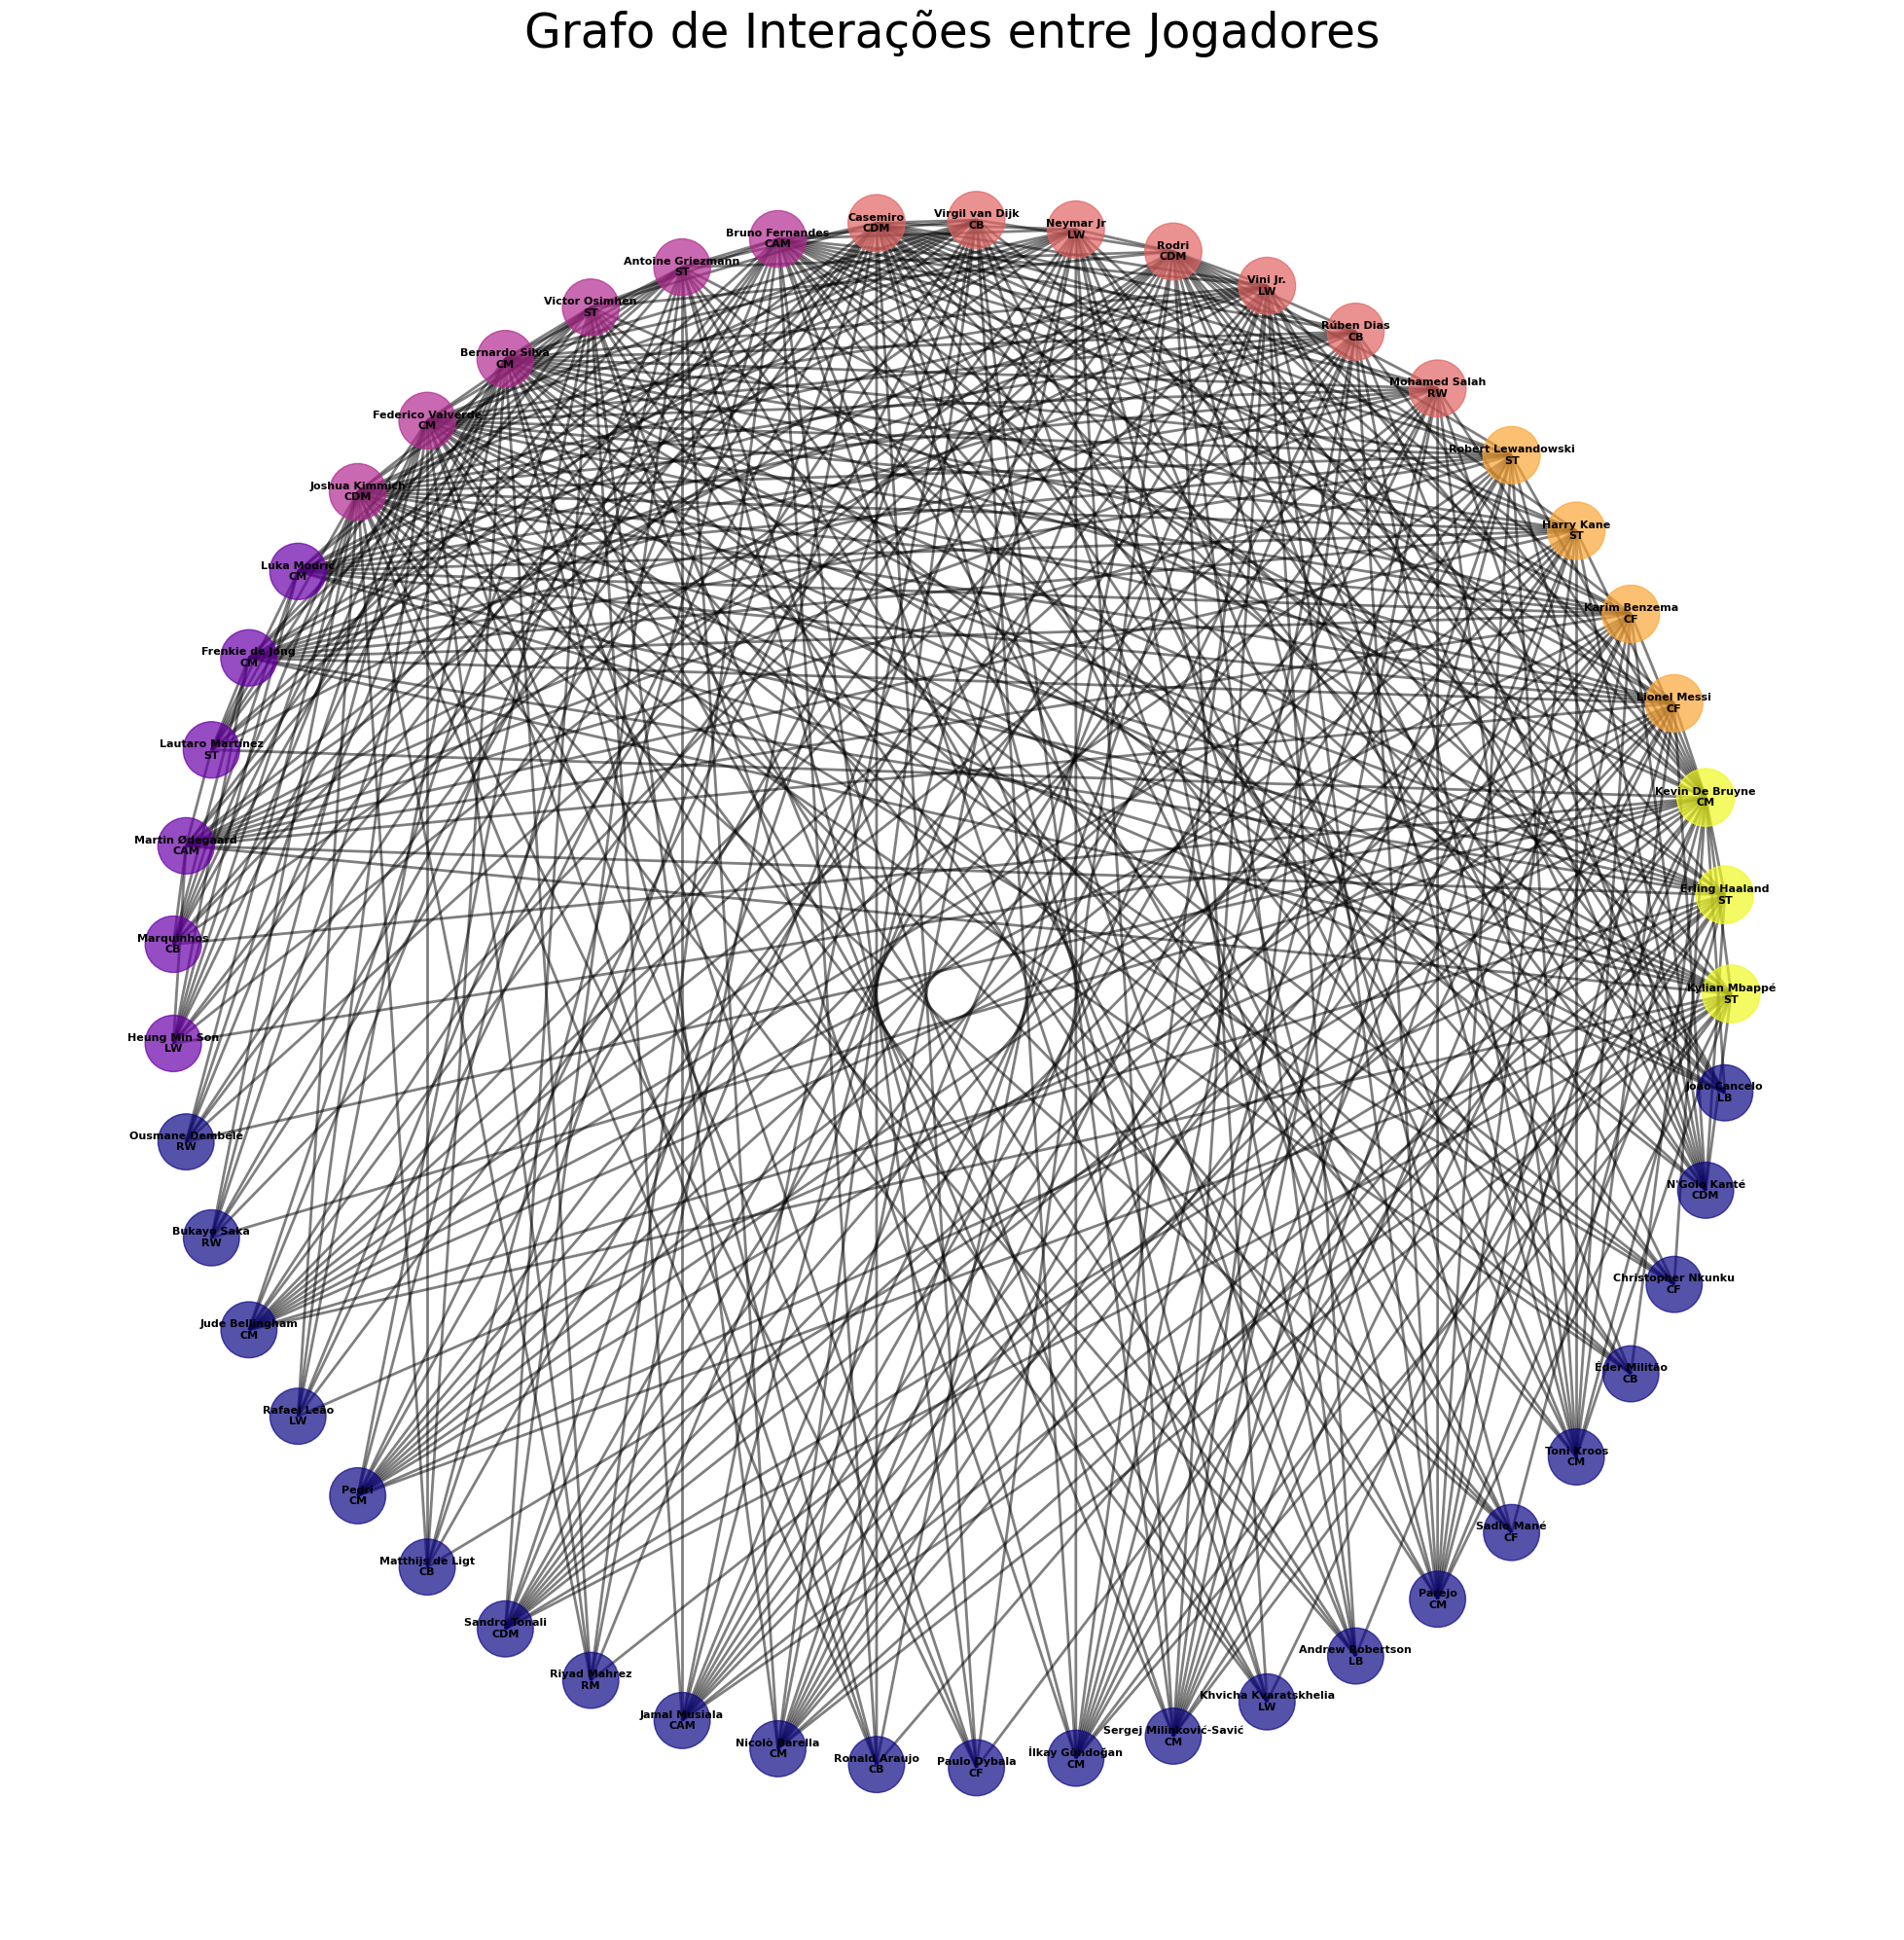

O grafo tem 385 arestas.


In [11]:
# Importando as bibliotecas necessárias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Carregando o conjunto de dados
file_path = 'players_filtrado_final.csv'
players_data = pd.read_csv(file_path)

# Criando um grafo vazio
G = nx.Graph()

# Adicionando vértices (cada jogador é um vértice no grafo)
for index, row in players_data.iterrows():
    G.add_node(row['Name'], position=row['Position'], overall=row['Overall'])

# Agrupando jogadores por posição
players_by_position = defaultdict(list)
for index, row in players_data.iterrows():
    players_by_position[row['Position']].append(row)

# Definindo interações entre posições levando em consideração os grupos
position_interactions = {
    'Zagueiro Central': ['Lateral Direito', 'Lateral Esquerdo'],
    'Zagueiro Esquerdo': ['Lateral Esquerdo', 'Meia-Esquerda'],
    'Zagueiro Direito': ['Lateral Direito', 'Meia-Direita'],
    'Lateral Direito': ['Zagueiro Direito', 'Meia-Direita'],
    'Lateral Esquerdo': ['Zagueiro Esquerdo', 'Meia-Esquerda', 'Meia-Central'],
    'Meia-Central': ['Zagueiro Central', 'Zagueiro Direito', 'Zagueiro Esquerdo', 'Meia-Direita', 'Meia-Esquerda', 'Atacante'],
    'Meia-Direita': ['Lateral Direito', 'Meia-Central', 'Ponta-Direita'],
    'Meia-Esquerda': ['Lateral Esquerdo', 'Ponta-Esquerda'],
    'Ponta-Esquerda': ['Meia-Esquerda', 'Atacante'],
    'Atacante': ['Ponta-Esquerda', 'Ponta-Direita'],
    'Ponta-Direita': ['Meia-Direita', 'Atacante'],
}

# Mapeamento de posição individual para grupo de posição
grouped_positions = {
    'CB': 'Zagueiro Central',
    'LB': 'Zagueiro Esquerdo',
    'RB': 'Zagueiro Direito',
    'RWB': 'Lateral Direito',
    'LWB': 'Lateral Esquerdo',
    'CDM': 'Meia-Central', 'CM': 'Meia-Central', 'CAM': 'Meia-Central',
    'ROM': 'Meia-Direita', 'RM': 'Meia-Direita', 'RWM': 'Meia-Direita', 'RW': 'Meia-Direita',
    'LOM': 'Meia-Esquerda', 'LM': 'Meia-Esquerda', 'LWM': 'Meia-Esquerda', 'LW': 'Meia-Esquerda',
    'LF': 'Ponta-Esquerda', 'LS': 'Ponta-Esquerda',
    'ST': 'Atacante', 'CF': 'Atacante',
    'RF': 'Ponta-Direita', 'RS': 'Ponta-Direita',
}

# Definindo o threshold de 'Overall'
threshold = 87

# Adicionando arestas com base em interações e threshold de 'Overall'
for index, player in players_data.iterrows():
    player_group = grouped_positions.get(player['Position'], None)
    if player_group:
        for target_group in position_interactions[player_group]:
            for target_position, target_position_group in grouped_positions.items():
                if target_position_group == target_group:
                    for target_player in players_by_position[target_position]:
                        avg_overall = (player['Overall'] + target_player['Overall']) / 2
                        if avg_overall >= threshold:
                            G.add_edge(player['Name'], target_player['Name'], weight=avg_overall)


# Configuração para a visualização do grafo
plt.figure(figsize=(25, 25))  # Aumentar o tamanho da figura para melhor visualização
pos = nx.circular_layout(G)  # Mudando para um layout circular para espaçar uniformemente os nós

# Desenhando as arestas com uma largura visível e cor diferente
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='black')

# Desenhando os nós com um tamanho baseado no 'Overall', mas reduzido para evitar sobreposição
node_size = [G.nodes[node]['overall'] * 20 for node in G]  # Reduzindo o tamanho dos nós
node_color = [G.nodes[node]['overall'] for node in G]  # Cor dos nós baseado no 'Overall'
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, alpha=0.7)

# Desenhando os rótulos dentro dos nós
labels = {node: f"{node}\n{G.nodes[node]['position']}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold', verticalalignment='center')

plt.title("Grafo de Interações entre Jogadores", size=35)
plt.axis('off')  # Remove os eixos para uma visualização mais limpa
plt.show()

# Verifique se as arestas foram criadas
print(f"O grafo tem {G.number_of_edges()} arestas.")

/tmp/ipykernel_7219/3741572770.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', len(unique_communities))


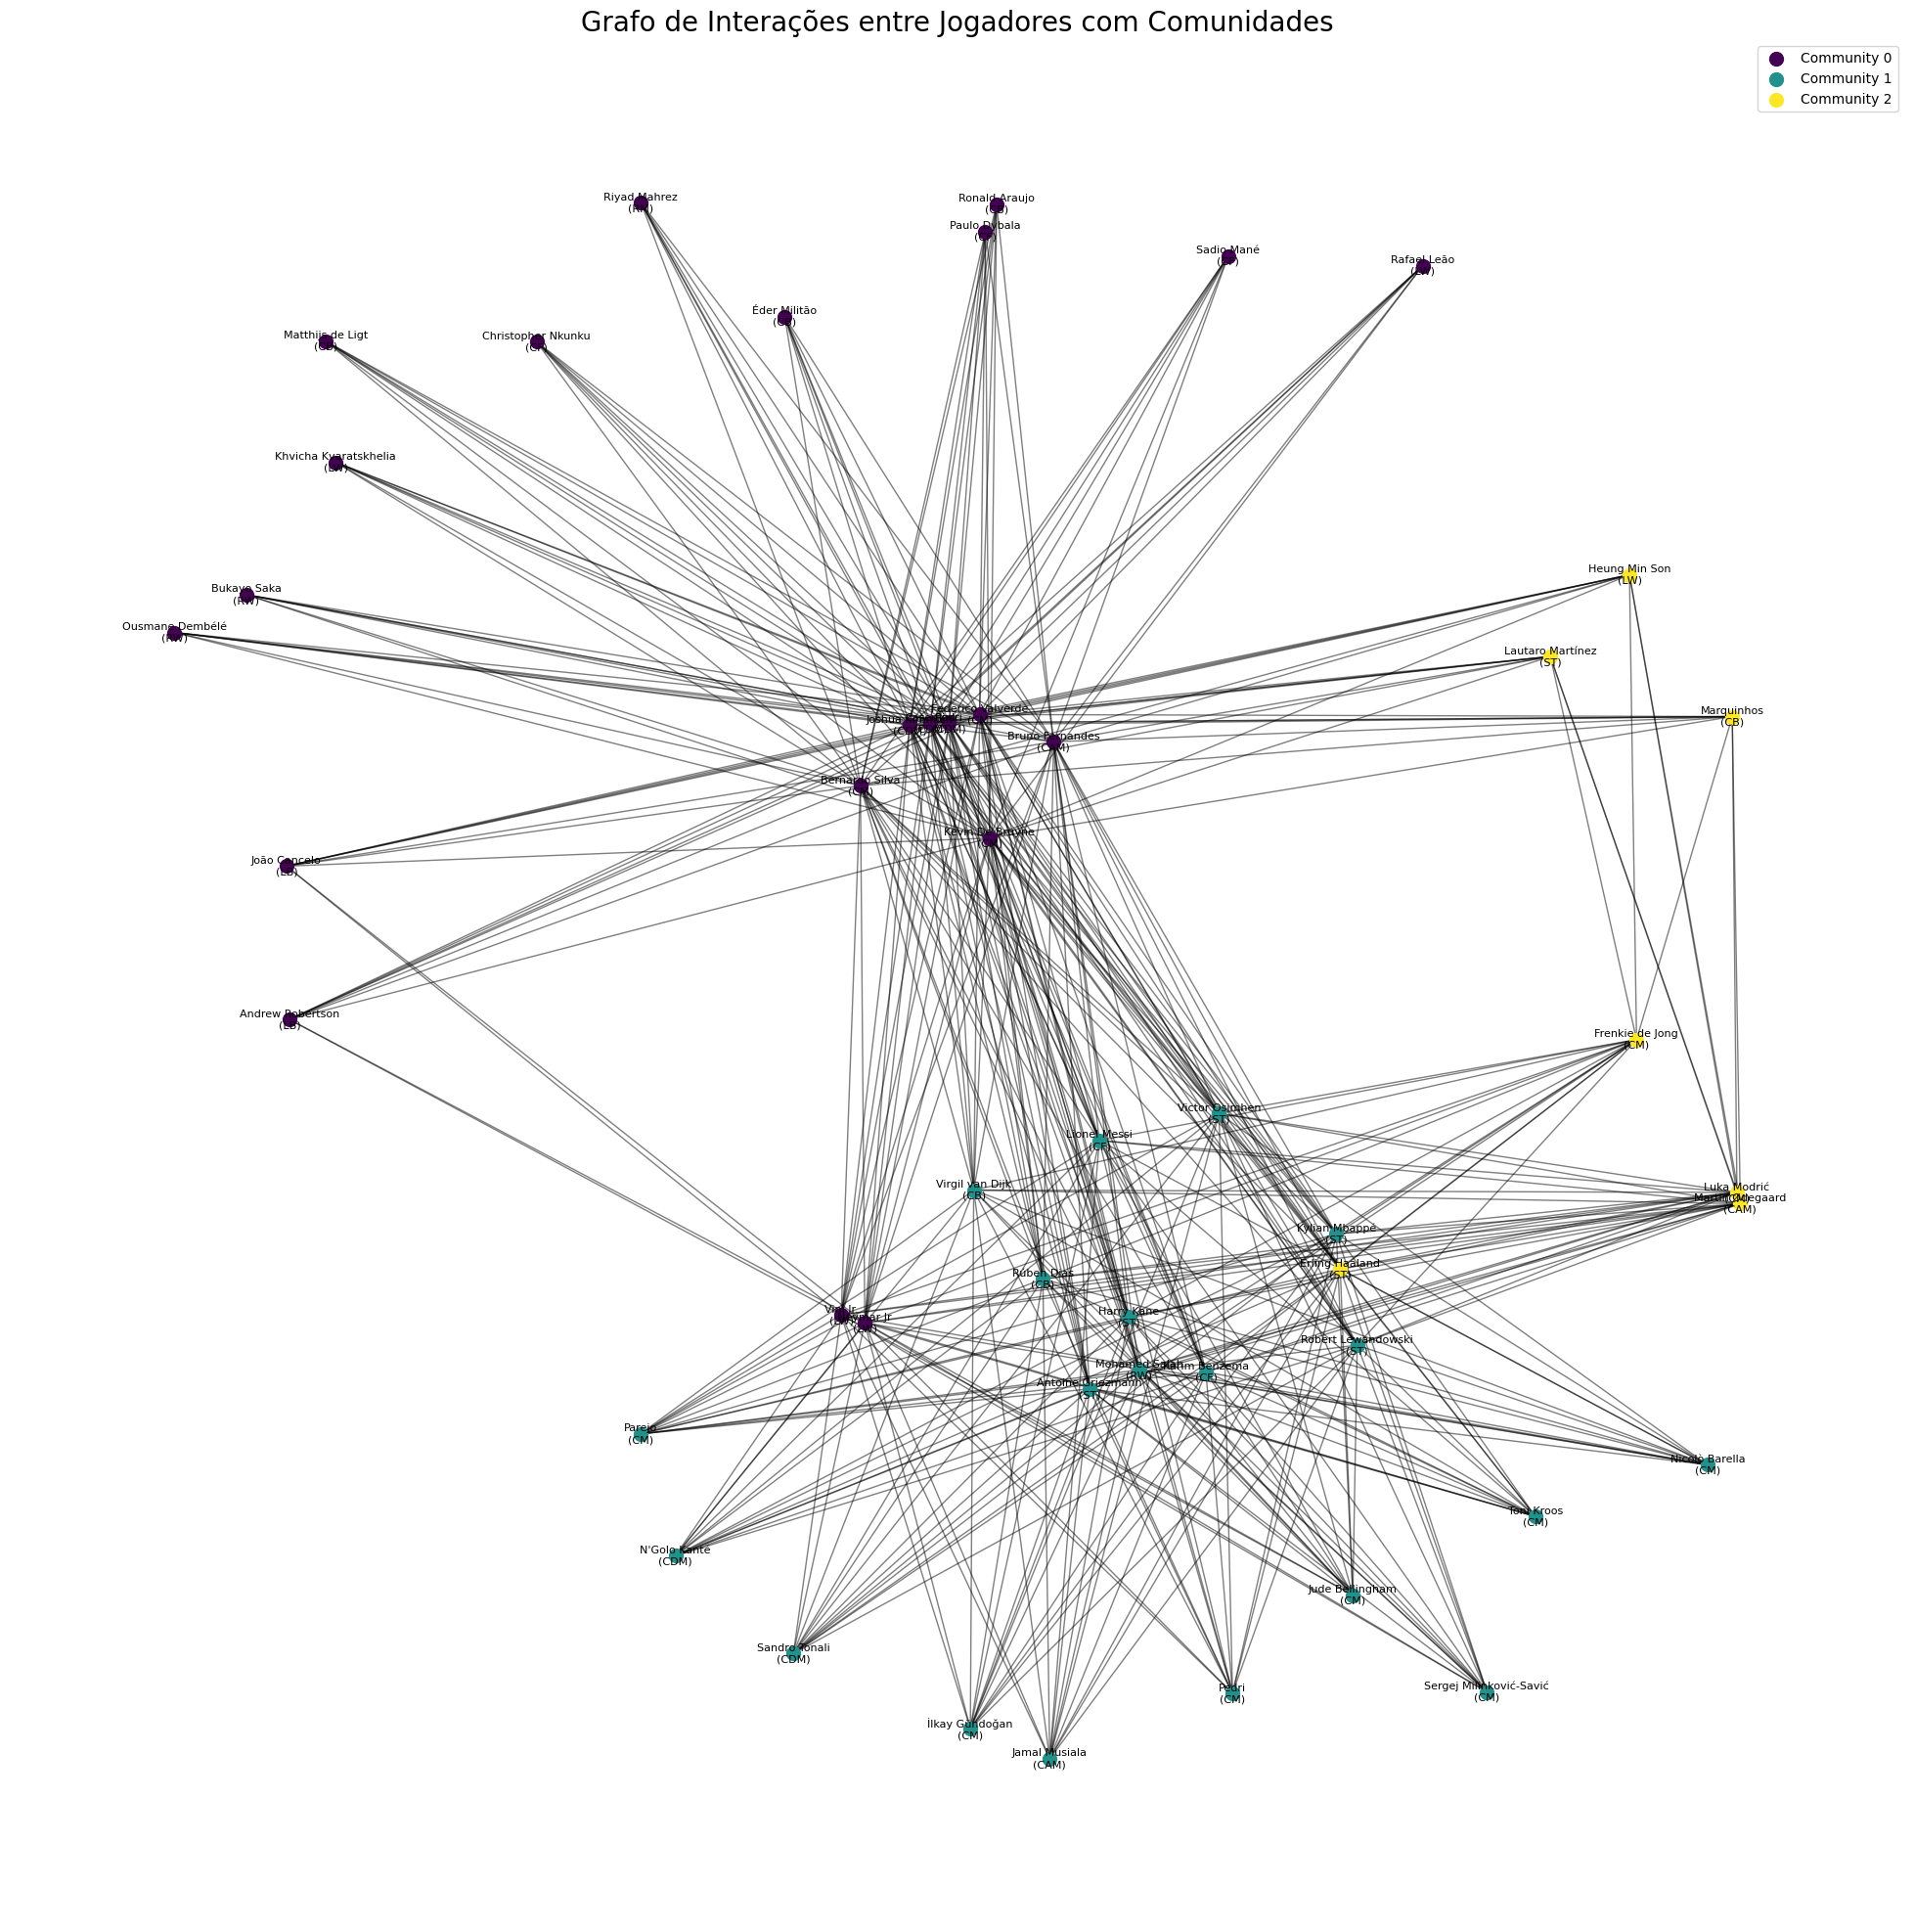

Número de comunidades encontradas: 3


In [12]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.cm as cm

# Detectar comunidades com o algoritmo greedy_modularity_communities
communities = community.greedy_modularity_communities(G, weight='weight')

# Criar um dicionário que mapeia cada nó para a comunidade a que pertence
community_map = {}
for community_number, community_nodes in enumerate(communities):
    for node in community_nodes:
        community_map[node] = community_number

# Adicionar o número da comunidade como um atributo no grafo
nx.set_node_attributes(G, community_map, 'community')

# Obter uma lista única de comunidades
unique_communities = list(set(community_map.values()))

# Definir uma cor para cada comunidade
colors = cm.get_cmap('viridis', len(unique_communities))

# Inicializar o espaço do gráfico
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, seed=42)  # Usando o mesmo layout que o grafo original

# Desenhar os nós, coloridos por comunidade
for community_number in unique_communities:
    nodes_in_community = [node for node in G.nodes() if G.nodes[node]['community'] == community_number]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=[G.nodes[node]['overall'] * 20 for node in nodes_in_community],
                           node_color=[colors(community_number)], label=f"Community {community_number}", alpha=0.7)

# Desenhar as arestas
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Desenhar os rótulos dos nós com o nome e a posição
labels = {node: f"{node}\n({G.nodes[node]['position']})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold', verticalalignment='center')

# Exibir a legenda
plt.legend(scatterpoints=1)

# Exibir o gráfico
plt.title("Grafo de Interações entre Jogadores com Comunidades", size=20)
plt.axis('off')
plt.show()

# Exibir o número de comunidades encontradas
print(f"Número de comunidades encontradas: {len(unique_communities)}")